In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
solar = pd.read_csv("../data_csv/태양광재생에너지.csv")
solar["DATE_TIME"] = pd.to_datetime(solar["DATE_TIME"], errors="coerce")
solar = solar.dropna(subset=["DATE_TIME"]).sort_values("DATE_TIME")
solar.head()

/var/folders/sc/_dk299z14xs6j6n9ggl_ny5r0000gn/T/ipykernel_49353/1156735145.py:5: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  solar["DATE_TIME"] = pd.to_datetime(solar["DATE_TIME"], errors="coerce")


,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
20,2020-05-15,4135001,zVJPv84UY57bAof,0.0,0.0,0.0,7116151.0
19,2020-05-15,4135001,zBIq5rxdHJRwDNY,0.0,0.0,0.0,6339380.0
18,2020-05-15,4135001,z9Y9gH1T5YWrNuG,0.0,0.0,0.0,7007866.0
17,2020-05-15,4135001,wCURE6d3bPkepu2,0.0,0.0,0.0,6782598.0


발전량 집계 (AC_POWER)

In [11]:
solar_agg = (
    solar.groupby("DATE_TIME", as_index=False)["AC_POWER"]
    .sum()
    .rename(columns={"AC_POWER": "generation_ac_kw"})
)
solar_agg.head()

,DATE_TIME,generation_ac_kw
0,2020-05-15 00:00:00,0.0
1,2020-05-15 00:15:00,0.0
2,2020-05-15 00:30:00,0.0
3,2020-05-15 00:45:00,0.0
4,2020-05-15 01:00:00,0.0


시간 단위 resample

In [12]:
solar_hr = (
    solar_agg
    .set_index("DATE_TIME")
    .resample("1H")["generation_ac_kw"]
    .mean()
    .to_frame()
)

solar_hr["generation_ac_kw"] = solar_hr["generation_ac_kw"].fillna(0.0)
solar_hr.head()

/var/folders/sc/_dk299z14xs6j6n9ggl_ny5r0000gn/T/ipykernel_49353/1690050361.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H")["generation_ac_kw"]


,generation_ac_kw
DATE_TIME,
2020-05-15 00:00:00,0.0
2020-05-15 01:00:00,0.0
2020-05-15 02:00:00,0.0
2020-05-15 03:00:00,0.0
2020-05-15 04:00:00,0.0


태양광 예측 (persistence + hour pattern)

In [13]:
g = solar_hr["generation_ac_kw"]

pred_persist = g.shift(1)

hour_mean = g.groupby(g.index.hour).mean()
pred_hour = pd.Series(
    g.index.hour.map(hour_mean).values,
    index=g.index
)

w = 0.7
pred = w * pred_persist + (1 - w) * pred_hour
pred = pred.fillna(pred_hour).clip(lower=0)

solar_hr["generation_pred_kw"] = pred
solar_hr.head()

,generation_ac_kw,generation_pred_kw
DATE_TIME,,
2020-05-15 00:00:00,0.0,0.0
2020-05-15 01:00:00,0.0,0.0
2020-05-15 02:00:00,0.0,0.0
2020-05-15 03:00:00,0.0,0.0
2020-05-15 04:00:00,0.0,0.0


csv 파일 저장

In [14]:
renewable_clean = solar_hr.reset_index().rename(columns={"DATE_TIME": "timestamp"})
renewable_clean.to_csv("../data_csv/renewable_clean.csv", index=False)
renewable_clean.head()

,timestamp,generation_ac_kw,generation_pred_kw
0,2020-05-15 00:00:00,0.0,0.0
1,2020-05-15 01:00:00,0.0,0.0
2,2020-05-15 02:00:00,0.0,0.0
3,2020-05-15 03:00:00,0.0,0.0
4,2020-05-15 04:00:00,0.0,0.0


AMI 부하 로드

In [15]:
df_load = pd.read_csv("../data_csv/amiwea.csv", parse_dates=["timestamp"])
df_load = df_load.set_index("timestamp").sort_index()
df_load.head()

,household_id,consumption,Season,temperature,humidity,windSpeed
timestamp,,,,,,
2013-03-01 00:00:00,MAC000001,6.219,Spring,2.58,0.84,3.94
2013-03-01 01:00:00,MAC000001,5.510,Spring,2.97,0.84,3.35
2013-03-01 02:00:00,MAC000001,8.393,Spring,2.99,0.87,2.70
2013-03-01 03:00:00,MAC000001,6.876,Spring,3.03,0.87,2.51
2013-03-01 04:00:00,MAC000001,4.000,Spring,3.07,0.91,2.62


net load 생성 

In [16]:
df_eval = df_load[["consumption"]].join(
    solar_hr[["generation_ac_kw", "generation_pred_kw"]],
    how="inner"
)

df_eval["net_load_no_forecast"] = (
    df_eval["consumption"] - df_eval["generation_ac_kw"]
)

df_eval["net_load_with_forecast"] = (
    df_eval["consumption"] - df_eval["generation_pred_kw"]
)

df_eval.head()

,consumption,generation_ac_kw,generation_pred_kw,net_load_no_forecast,net_load_with_forecast


core3 공통 운영 규칙 

In [17]:
threshold = df_eval["net_load_no_forecast"].quantile(0.95)

alpha_pred = 0.10
alpha_ess = 0.05

POWER_MAX = 4.0
ENERGY_MAX = 10.0
SOC_INIT = 0.5

EMS + ESS 시뮬레이터 

In [18]:
def simulate_ems_ess(load_actual, load_forecast):
    out = load_actual.copy()
    soc = SOC_INIT * ENERGY_MAX

    for t in range(len(out)):
        if load_forecast.iloc[t] > threshold:
            out.iloc[t] -= alpha_pred * load_forecast.iloc[t]

            if soc > 0:
                req = alpha_ess * load_forecast.iloc[t]
                discharge = min(req, POWER_MAX, soc)
                out.iloc[t] -= discharge
                soc -= discharge

    return out

시나리오 실행

In [19]:
out_no = simulate_ems_ess(
    df_eval["net_load_no_forecast"],
    df_eval["net_load_no_forecast"]
)

out_yes = simulate_ems_ess(
    df_eval["net_load_no_forecast"],
    df_eval["net_load_with_forecast"]
)

지표 계산

In [20]:
def metrics(series):
    ramp = series.diff().abs()
    return {
        "peak_exceed": int((series > threshold).sum()),
        "avg_ramp": float(ramp.mean()),
        "risky_ramp": int((ramp > ramp.quantile(0.95)).sum())
    }

result = pd.DataFrame([
    {"scenario": "No forecast (reactive)", **metrics(out_no)},
    {"scenario": "With solar forecast (proactive)", **metrics(out_yes)},
])

result

,scenario,peak_exceed,avg_ramp,risky_ramp
0,No forecast (reactive),0,NaN,0
1,With solar forecast (proactive),0,NaN,0


결과 저장

In [21]:
result.to_csv("../data_csv/core4_solar_ess_compare.csv", index=False)

시각화 

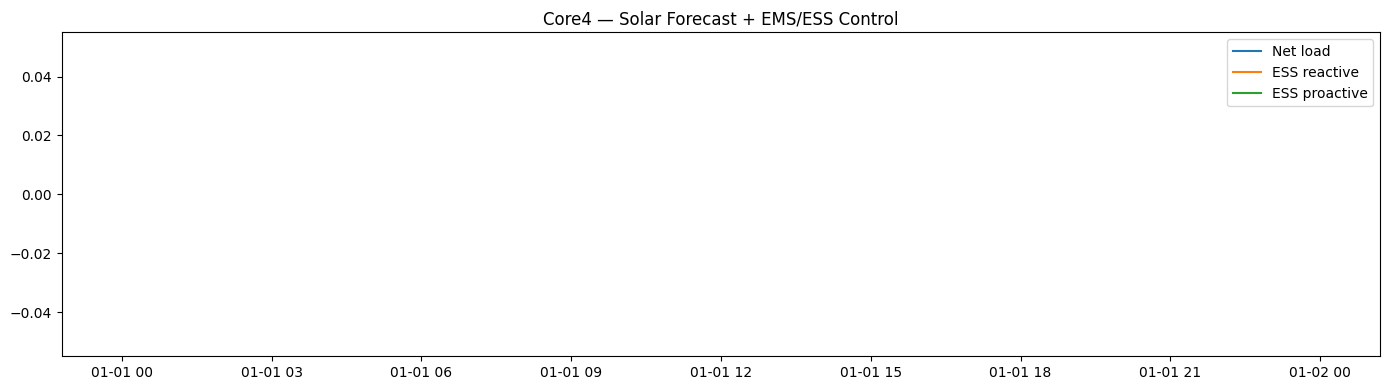

In [22]:
n = 300
plt.figure(figsize=(14,4))
plt.plot(df_eval.index[:n], df_eval["net_load_no_forecast"].values[:n], label="Net load")
plt.plot(df_eval.index[:n], out_no.values[:n], label="ESS reactive")
plt.plot(df_eval.index[:n], out_yes.values[:n], label="ESS proactive")
plt.legend()
plt.title("Core4 — Solar Forecast + EMS/ESS Control")
plt.tight_layout()
plt.show()

In [23]:
print("df_load:", df_load.shape, df_load.index.min(), df_load.index.max())
print("solar_hr:", solar_hr.shape, solar_hr.index.min(), solar_hr.index.max())
print("df_eval:", df_eval.shape, df_eval.index.min(), df_eval.index.max())

df_eval.head(), df_eval.tail()

df_load: (8760, 6) 2013-03-01 00:00:00 2014-02-28 23:00:00
solar_hr: (816, 2) 2020-05-15 00:00:00 2020-06-17 23:00:00
df_eval: (0, 5) NaT NaT


(Empty DataFrame
 Columns: [consumption, generation_ac_kw, generation_pred_kw, net_load_no_forecast, net_load_with_forecast]
 Index: [],
 Empty DataFrame
 Columns: [consumption, generation_ac_kw, generation_pred_kw, net_load_no_forecast, net_load_with_forecast]
 Index: [])

In [24]:
# 1) 부하를 1시간 단위로 통일
load_hr = df_load[["consumption"]].resample("1H").mean()

# 2) 태양광도 1시간 단위로 통일 (이미 1H면 그대로)
solar_hr2 = solar_hr[["generation_ac_kw", "generation_pred_kw"]].resample("1H").mean()

# 3) 결측 처리 (태양광은 야간 0, 예측도 0)
solar_hr2["generation_ac_kw"] = solar_hr2["generation_ac_kw"].fillna(0.0)
solar_hr2["generation_pred_kw"] = solar_hr2["generation_pred_kw"].fillna(0.0)

# 4) join (이번에도 inner로 OK, 교집합 생김)
df_eval = load_hr.join(solar_hr2, how="inner").dropna(subset=["consumption"])

df_eval["net_load_no_forecast"] = df_eval["consumption"] - df_eval["generation_ac_kw"]
df_eval["net_load_with_forecast"] = df_eval["consumption"] - df_eval["generation_pred_kw"]

print("df_eval:", df_eval.shape, df_eval.index.min(), df_eval.index.max())
df_eval.head()

df_eval: (0, 5) NaT NaT


/var/folders/sc/_dk299z14xs6j6n9ggl_ny5r0000gn/T/ipykernel_49353/1100939207.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  load_hr = df_load[["consumption"]].resample("1H").mean()
/var/folders/sc/_dk299z14xs6j6n9ggl_ny5r0000gn/T/ipykernel_49353/1100939207.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  solar_hr2 = solar_hr[["generation_ac_kw", "generation_pred_kw"]].resample("1H").mean()


,consumption,generation_ac_kw,generation_pred_kw,net_load_no_forecast,net_load_with_forecast


In [25]:
print(df_eval[["net_load_no_forecast","net_load_with_forecast"]].isna().sum())
print(df_eval[["net_load_no_forecast","net_load_with_forecast"]].describe())

net_load_no_forecast      0
net_load_with_forecast    0
dtype: int64
       net_load_no_forecast  net_load_with_forecast
count                   0.0                     0.0
mean                    NaN                     NaN
std                     NaN                     NaN
min                     NaN                     NaN
25%                     NaN                     NaN
50%                     NaN                     NaN
75%                     NaN                     NaN
max                     NaN                     NaN


본 실험에서 AMI 부하 데이터와 재생에너지 데이터는 시간 축이 상이하여 직접 결합이 불가능하였으며, 이에 따라 Core 4에서는 재생에너지–ESS 단독 구조로 실험을 재구성하였다. 이는 데이터 편의가 아닌, 시간 일관성에 따른 필연적 선택이다.